## Imports

In [1]:
from sensn_framework import CNN_MNIST
import xai_funcs
import numpy as np
import tensorflow as tf

## Import do Modelo

In [2]:
modelo = CNN_MNIST()
modelo.setup()
print("Precisão:", modelo.model_accuracy())

A carregar dataset


I0000 00:00:1767471310.051800 2659570 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6624 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2070, pci bus id: 0000:07:00.0, compute capability: 7.5


Dataser carregado
A separar dataset
Shape das Imagens: (28, 28, 1)
Exemplo de Labels: 0
Train: 56000
Val: 7000
Test: 7000
Dataset separado
Modelo encontrado!


I0000 00:00:1767471313.291092 2659673 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Precisão: 0.9944285750389099


# Separar o test_ds em features e target

In [3]:
data_list = list(modelo.test_ds.as_numpy_iterator())

X_test, y_test = zip(*data_list)

# 3. Converter para arrays NumPy
X_test = np.array(X_test)
y_test = np.array(y_test)

print(f"Features shape: {X_test.shape}")
print(f"Target shape: {y_test.shape}")
print("Primeiros 5 exemplos do Target:", y_test[:5])

Features shape: (7000, 28, 28, 1)
Target shape: (7000,)
Primeiros 5 exemplos do Target: [2 5 3 1 5]


### Criar modelo para Smooth Gradient

In [4]:
inputs = tf.keras.Input(shape=(28, 28, 1))

outputs = modelo.modelo(inputs)

functional_model = tf.keras.Model(inputs=inputs, outputs=outputs)

# Exemplo de iteração do Sensitivity-N

In [5]:
idx = np.random.randint(0, len(X_test))

## Integrated Gradients

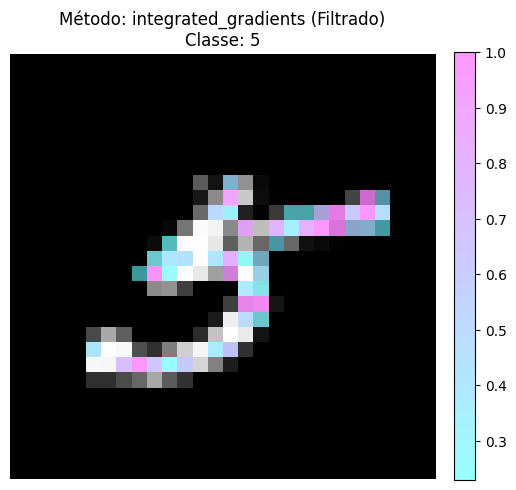

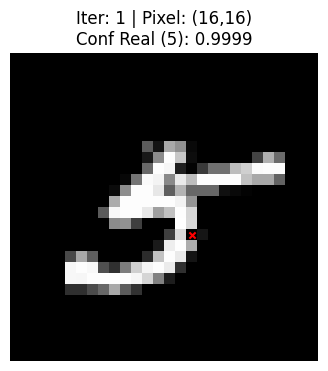

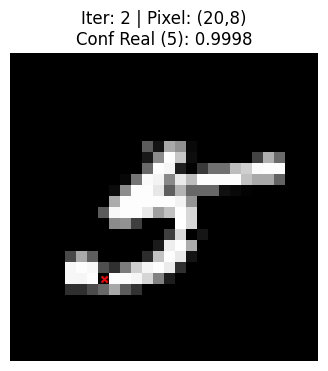

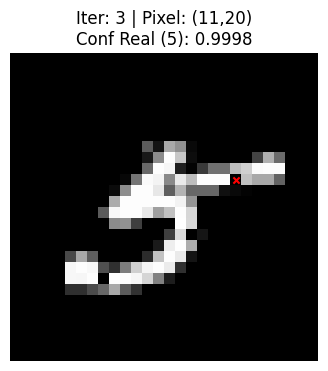

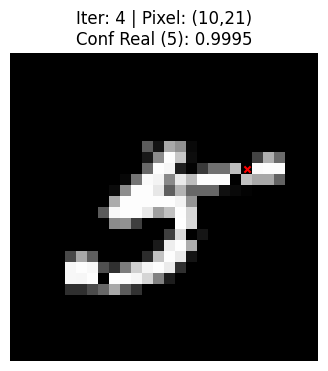

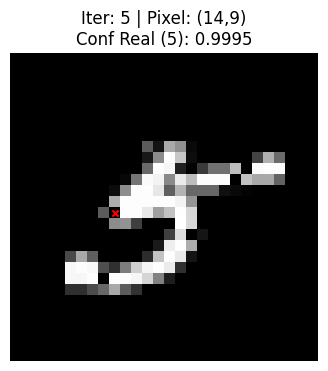

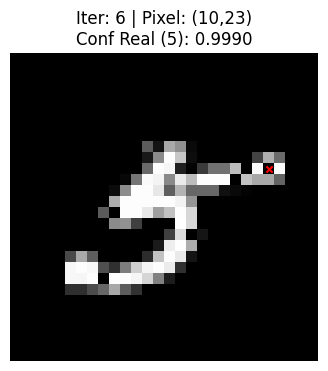

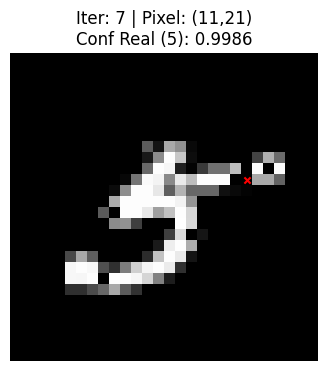

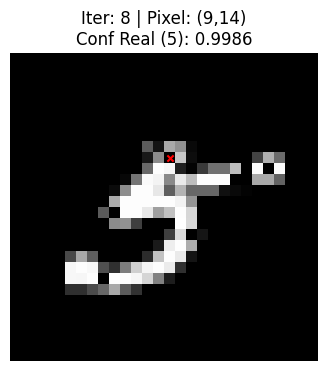

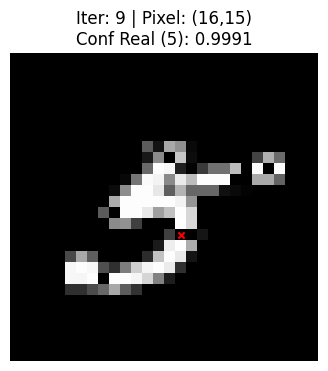

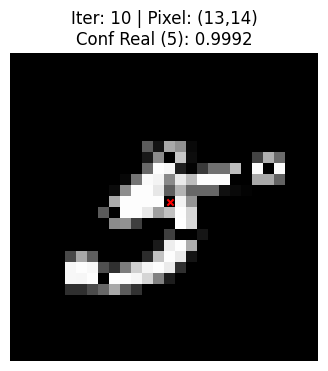

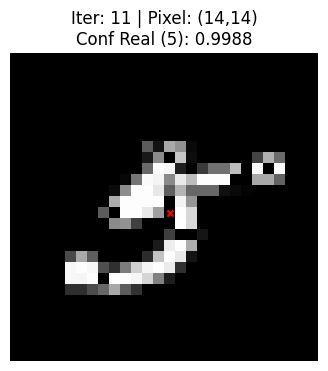

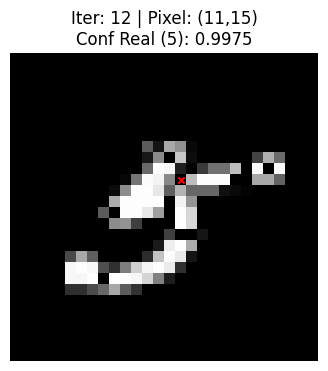

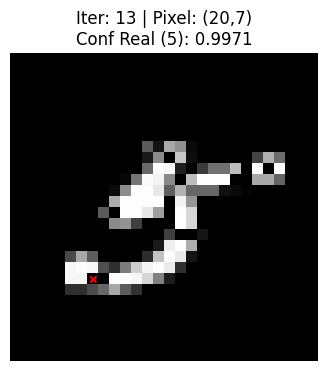

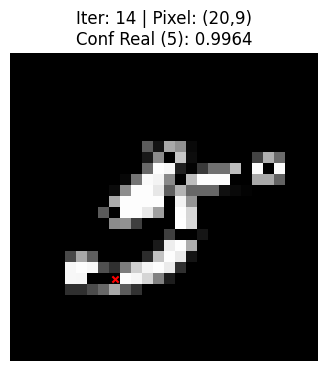

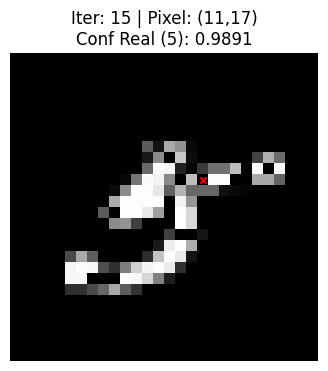

In [6]:
xai_funcs.display_explanation(modelo.modelo, X_test[idx], y_test[idx], "integrated_gradients", 0.2, 0.4)
xai_funcs.analise_iterativa_pixels(modelo.modelo, X_test[idx], y_test[idx], "integrated_gradients", 15)

## Gradient x Input

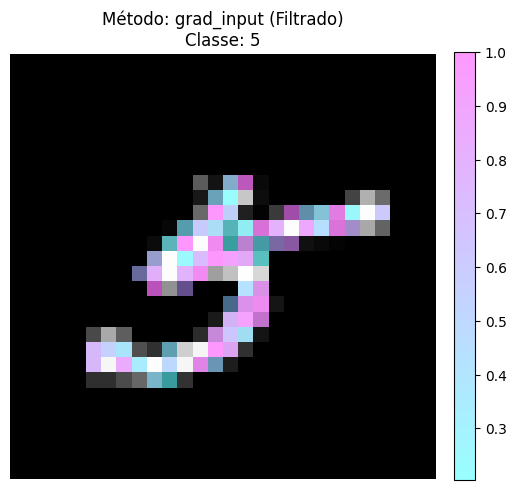

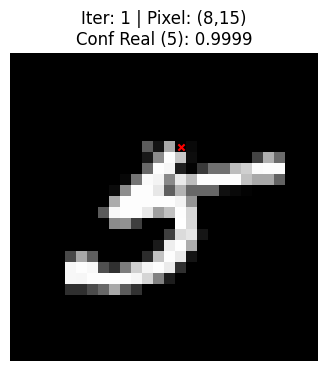

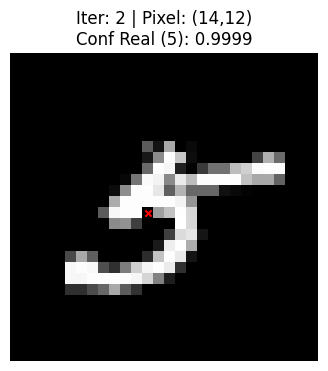

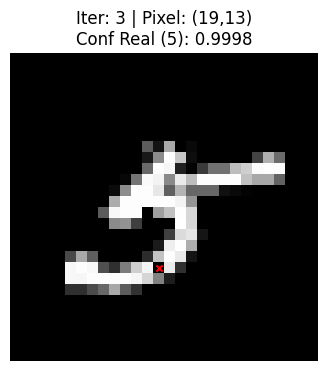

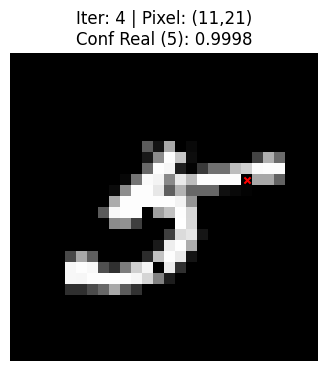

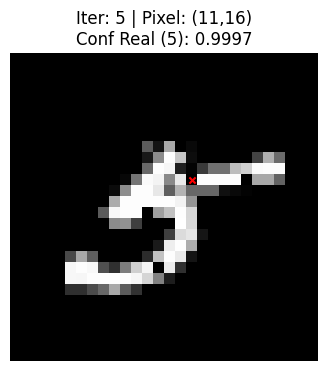

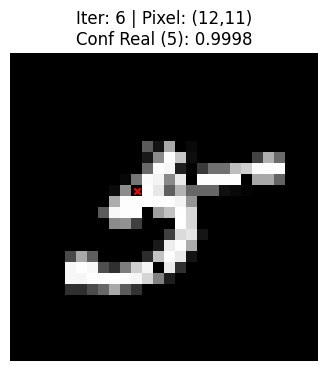

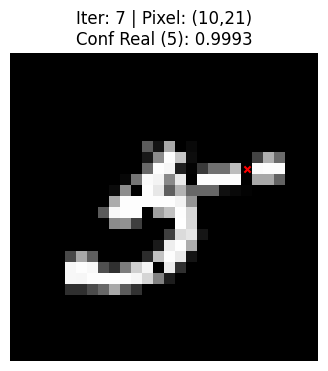

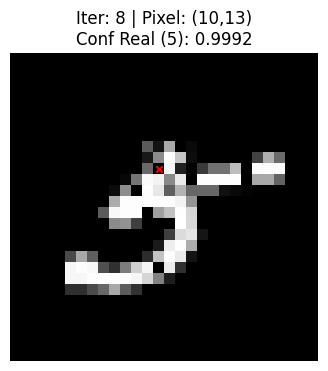

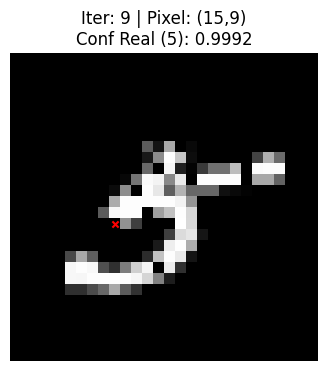

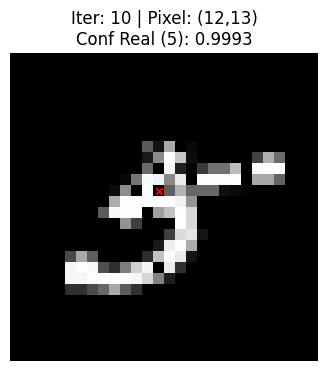

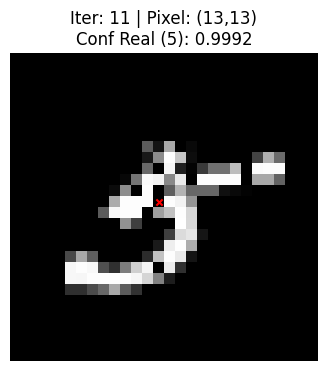

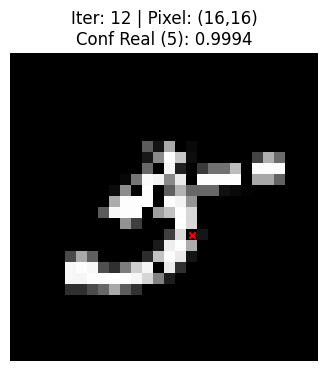

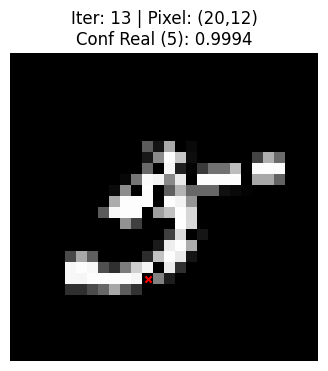

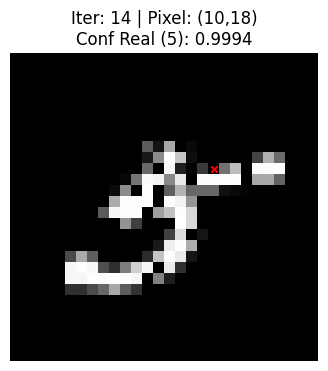

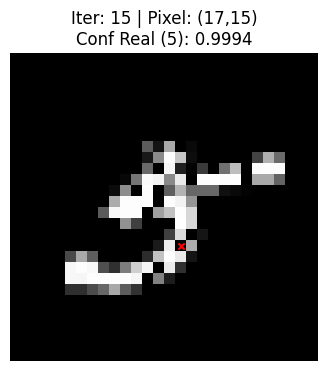

In [8]:
xai_funcs.display_explanation(modelo.modelo, X_test[idx], y_test[idx], "grad_input", 0.2, 0.4)
xai_funcs.analise_iterativa_pixels(modelo.modelo, X_test[idx], y_test[idx], "grad_input", 15)

## Smooth Gradients

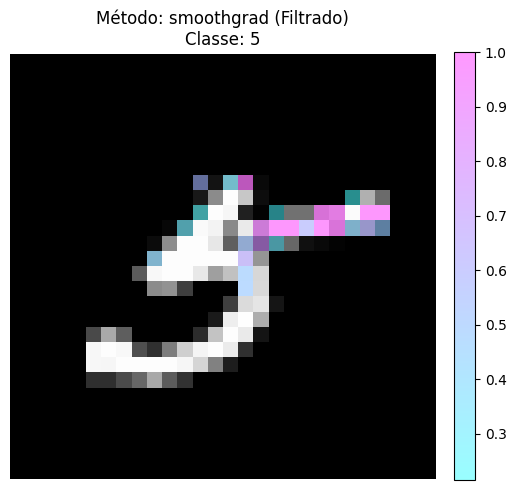

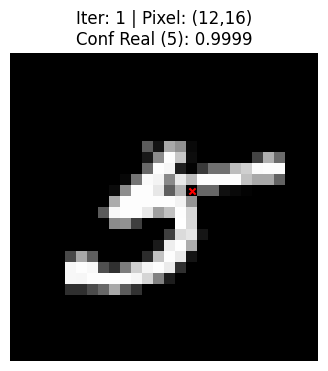

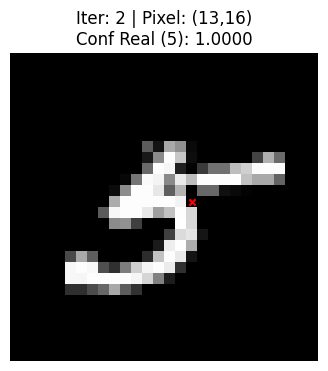

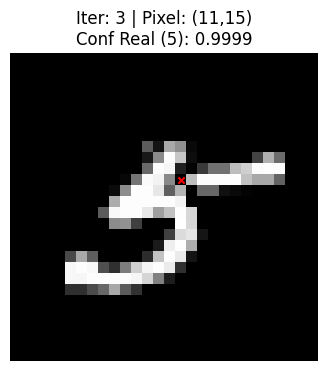

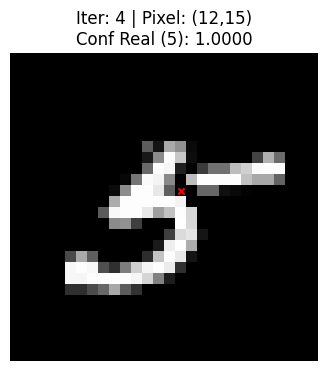

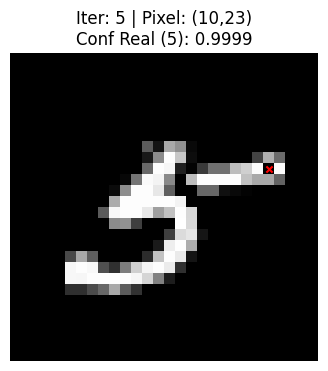

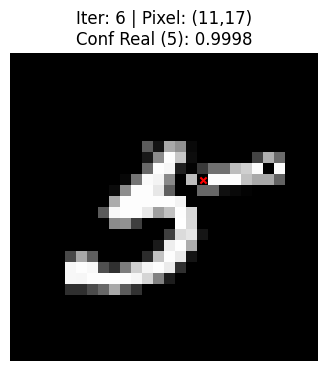

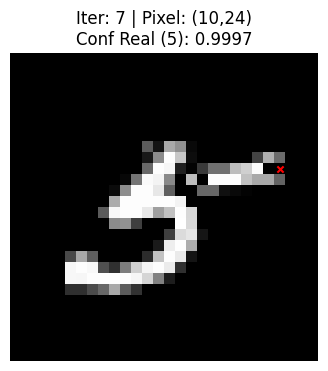

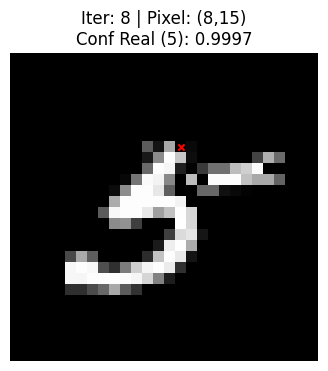

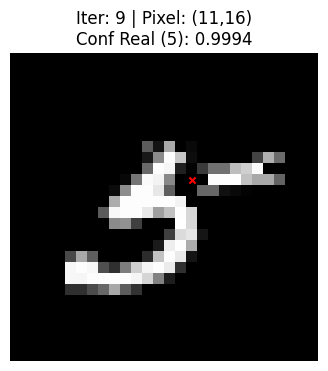

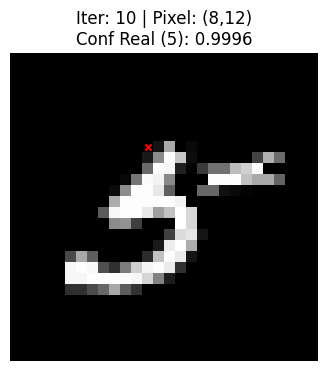

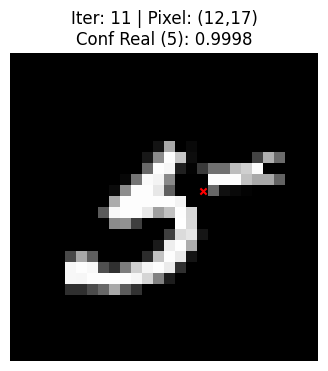

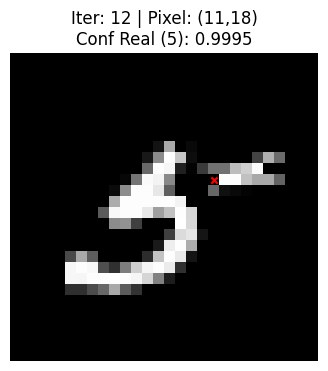

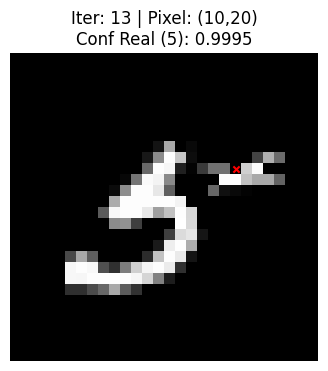

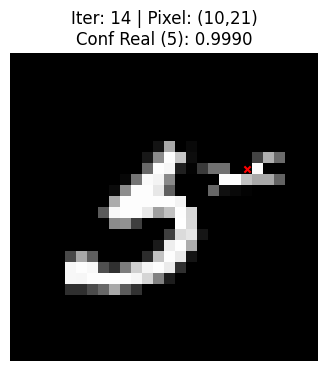

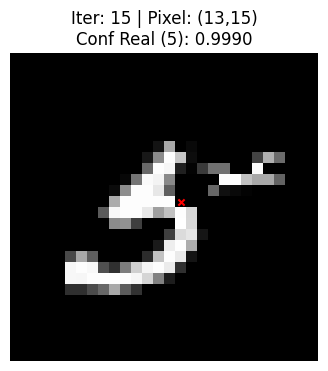

In [7]:
xai_funcs.display_explanation(functional_model, X_test[idx], y_test[idx], "smoothgrad", 0.2, 0.4)
xai_funcs.analise_iterativa_pixels(functional_model, X_test[idx], y_test[idx], "smoothgrad", 15)

# Diminuição dos Dados

In [9]:
# 2. Preparar os dados (se o teu dataset estiver num objeto custom, extrai arrays numpy)
# Exemplo assumindo que tens X_test e y_test
# Se estiver no objeto 'modelo', adapta:
data_list = list(modelo.test_ds.as_numpy_iterator())

# 2. Separar as features e os targets usando zip
# X será uma lista de imagens, y será uma lista de labels
X_test, y_test = zip(*data_list)

# 3. Converter para arrays NumPy
X_test = np.array(X_test)
y_test = np.array(y_test)


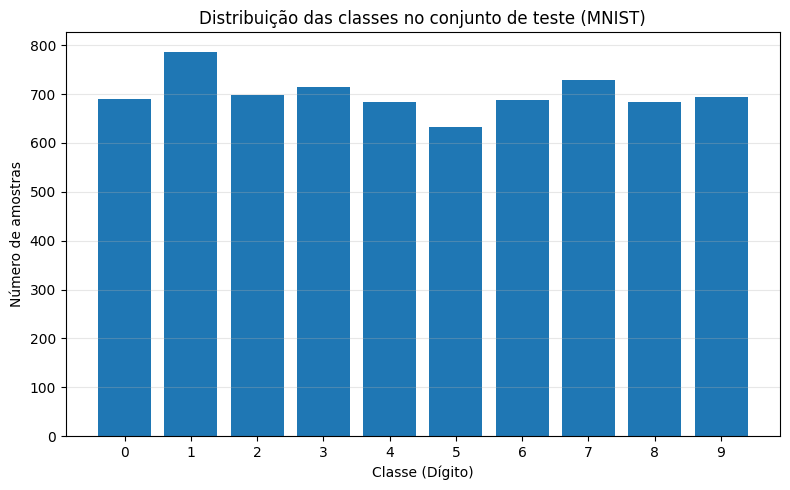

Classe 0: 690 amostras
Classe 1: 787 amostras
Classe 2: 699 amostras
Classe 3: 714 amostras
Classe 4: 683 amostras
Classe 5: 632 amostras
Classe 6: 688 amostras
Classe 7: 729 amostras
Classe 8: 683 amostras
Classe 9: 695 amostras


In [10]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

# Contagem das classes
class_counts = Counter(y_test)

# Ordenar por classe (0–9)
classes = sorted(class_counts.keys())
counts = [class_counts[c] for c in classes]

# Plot
plt.figure(figsize=(8, 5))
plt.bar(classes, counts)
plt.xticks(classes)
plt.xlabel("Classe (Dígito)")
plt.ylabel("Número de amostras")
plt.title("Distribuição das classes no conjunto de teste (MNIST)")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

# Print auxiliar
for c in classes:
    print(f"Classe {c}: {class_counts[c]} amostras")

In [11]:
X_test_strat, y_test_strat = xai_funcs.criar_subset_estratificado(
    X_test,
    y_test,
    samples_per_class=100
)

print("Shape X:", X_test_strat.shape)
print("Shape y:", y_test_strat.shape)

Shape X: (1000, 28, 28, 1)
Shape y: (1000,)


# Análises do Sensitivity

## Integrated Gradients

--- Sensitivity-n (integrated_gradients) | 1000 amostras ---


Processando integrated_gradients: 100%|██████████| 1000/1000 [02:59<00:00,  5.58it/s]


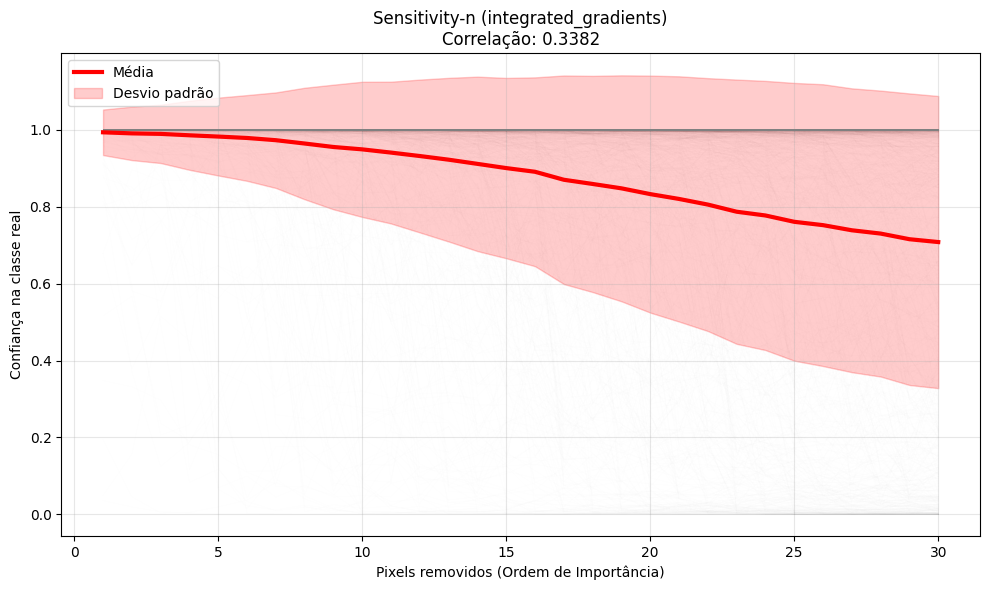

Correlação: 0.3382


In [12]:
results_ig = xai_funcs.analisar_sensitivity_n(
    model=modelo.modelo,
    images=X_test_strat, 
    labels=y_test_strat,
    method_name="integrated_gradients",
    max_n=30,
    num_samples=len(X_test_strat),
    batch_size=8
)

print(f"Correlação: {results_ig['correlation']:.4f}")

## Gradient x Input

--- Sensitivity-n (grad_input) | 1000 amostras ---


Processando grad_input:   0%|          | 2/1000 [00:00<06:45,  2.46it/s]

Processando grad_input:   0%|          | 3/1000 [00:01<06:45,  2.46it/s]

Processando grad_input: 100%|██████████| 1000/1000 [07:50<00:00,  2.12it/s]


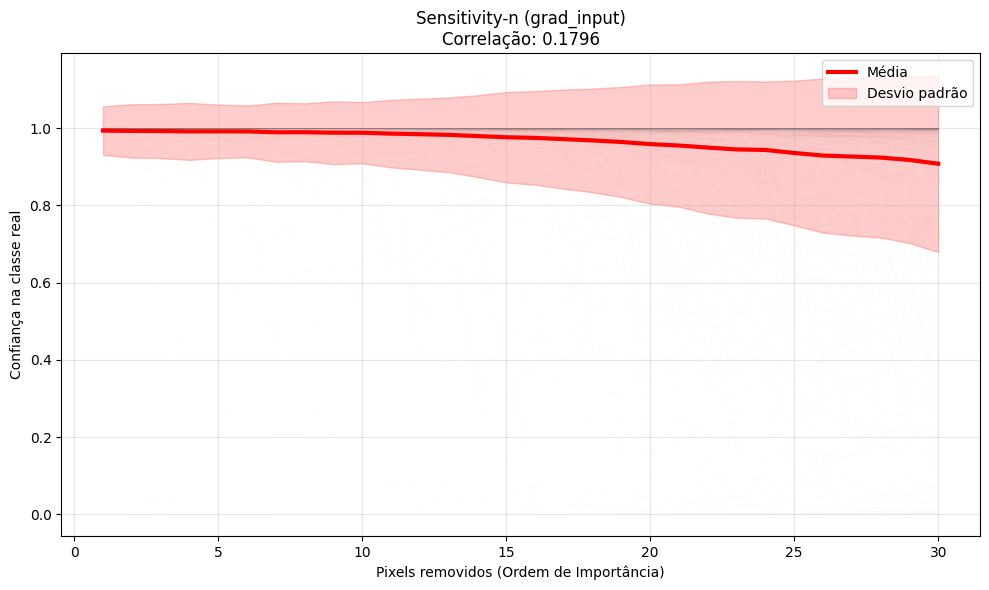

Correlação: 0.1796


In [13]:
results_gi = xai_funcs.analisar_sensitivity_n(
    model=modelo.modelo,
    images=X_test_strat, 
    labels=y_test_strat,
    method_name="grad_input",
    max_n=30,
    num_samples=len(X_test_strat),
    batch_size=8
)

print(f"Correlação: {results_gi['correlation']:.4f}")

## Smooth Gradients

--- Sensitivity-n (smoothgrad) | 1000 amostras ---


Processando smoothgrad: 100%|██████████| 1000/1000 [03:01<00:00,  5.51it/s]


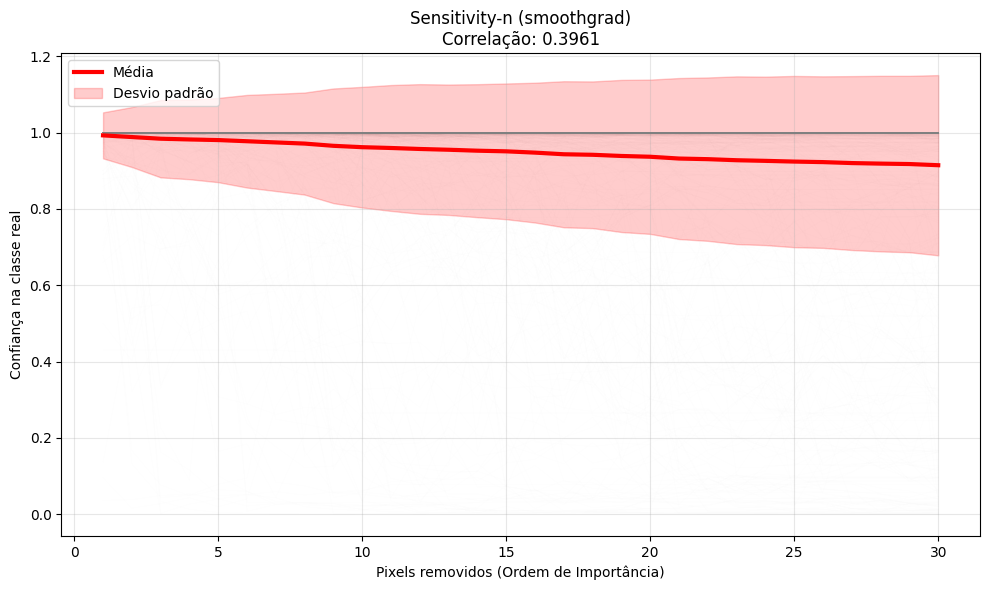

Correlação: 0.3961


In [14]:
results_sm = xai_funcs.analisar_sensitivity_n(
    model=functional_model,
    images=X_test_strat, 
    labels=y_test_strat,
    method_name="smoothgrad",
    max_n=30,
    num_samples=len(X_test_strat),
    batch_size=8
)

print(f"Correlação: {results_sm['correlation']:.4f}")